In [1]:
import pandas as pd
import numpy as np
import os
from string import punctuation
from collections import Counter
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from IPython.core.display import clear_output
from torch import autograd
%matplotlib inline

In [2]:
df = pd.read_csv("./review_data.csv", encoding = "ISO-8859-1")

In [3]:
supa = df[df.label != 'unsup']

In [4]:
labels = []
for label in supa.label:
    labels.append(label)
print(len(labels))
print(labels[0])

50000
neg


Write Labels into a text file.

In [5]:
data_labels = open("./review_data/labels.txt", "w")
for label in labels:
    data_labels.write(label)
    data_labels.write("\n")
data_labels.close()

In [6]:
reviews = []
for review in supa.review:
    reviews.append(review)
print(len(reviews))
print(reviews[0])

50000
Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.


Write reviews into text file

In [7]:
data_reviews = open("./review_data/reviews.txt", "w")
for review in reviews:
    data_reviews.write(review)
    data_reviews.write("\n")
data_reviews.close()

Read Data From Text Files

In [8]:
with open("review_data/reviews.txt", "r") as f:
    reviews = f.read()
with open("review_data/labels.txt", "r") as f:
    labels = f.read()

print(reviews[:50])
print()
print(labels[:26])

Once again Mr. Costner has dragged out a movie for

neg
neg
neg
neg
neg
neg
ne


Data Processesing - convert to lower case

In [9]:
reviews = reviews.lower()

Data Processing — remove punctuation

In [10]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
all_text = ''.join([c for c in reviews if c not in punctuation])

Data Processing — create list of reviews

In [12]:
vocab = set(all_text.split())
word2id = {word: id+1 for id, word in enumerate(vocab)}

In [13]:
# INITIALIZE EMBEDDINGS TO RANDOM VALUES
embed_size = 300
vocab_size = len(vocab)+1
sd = 1/np.sqrt(embed_size)  # Standard deviation to use
weights = np.random.normal(0, scale=sd, size=[vocab_size, embed_size])
weights = weights.astype(np.float32)

In [14]:
file = "./review_data/glove.6B.300d.txt"

# EXTRACT DESIRED GLOVE WORD VECTORS FROM TEXT FILE
with open(file, encoding="utf-8", mode="r") as textFile:
    for line in textFile:
        # Separate the values from the word
        line = line.split()
        word = line[0]

        # If word is in our vocab, then update the corresponding weights
        id = word2id.get(word, None)
        if id is not None:
            weights[id] = np.array(line[1:], dtype=np.float32)

In [15]:
reviews_split = all_text.split('\n')
print ('Number of reviews :', len(reviews_split))
labels_split = labels.split("\n")
print('Number of labels :{}'.format(len(labels_split)))

Number of reviews : 50001
Number of labels :50001


Tokenize — Create Vocab to Int mapping dictionary

In [16]:
# all_text2 = ' '.join(reviews_split)
# # create a list of words
# words = all_text2.split()
# # Count all the words using Counter Method
# count_words = Counter(words)

# total_words = len(words)
# sorted_words = count_words.most_common(total_words)

In [17]:
# print("Total Words: ",total_words)
# print("Word Count: ", len(count_words))

In [18]:
# print(count_words)

In [19]:
# vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

Leave Room for Padding for shorter reviews

In [20]:
# vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [21]:
# print(vocab_to_int)

Tokenize — Encode the words (replace words in reviews with integers)

In [22]:
reviews_int = []
for review in reviews_split:
    r = [float(word2id[w]) for w in review.split()]
    reviews_int.append(r)
print (reviews_int[0:3])

[[42446.0, 3096.0, 148885.0, 122577.0, 175763.0, 72798.0, 46946.0, 115161.0, 24806.0, 147409.0, 80423.0, 135373.0, 31413.0, 77860.0, 18990.0, 66234.0, 59999.0, 74755.0, 6231.0, 166710.0, 47456.0, 47949.0, 117081.0, 10353.0, 87605.0, 35986.0, 52984.0, 6738.0, 70944.0, 18429.0, 18403.0, 33888.0, 144428.0, 164225.0, 47949.0, 59999.0, 88404.0, 102786.0, 47949.0, 145987.0, 5718.0, 9257.0, 97114.0, 59999.0, 162786.0, 157378.0, 59664.0, 47500.0, 87605.0, 5592.0, 144332.0, 34890.0, 157378.0, 62462.0, 10923.0, 43503.0, 8676.0, 5630.0, 30994.0, 117081.0, 36578.0, 6738.0, 18429.0, 18403.0, 33888.0, 59999.0, 47500.0, 5844.0, 52104.0, 103817.0, 33888.0, 144428.0, 93925.0, 115161.0, 35986.0, 2372.0, 102411.0, 78435.0, 77708.0, 59999.0, 65463.0, 93925.0, 4137.0, 164538.0, 142154.0, 172667.0, 28494.0, 127768.0, 145375.0, 181117.0, 61980.0, 31413.0, 9351.0, 25358.0, 20797.0, 134430.0, 157378.0, 52137.0, 1576.0, 107580.0, 47949.0, 115161.0, 62225.0, 162786.0, 54054.0, 160647.0, 49281.0, 20954.0, 84560.0

 Tokenize — Encode the labels

In [23]:
encoded_labels = [1.0 if label =='pos' else 0.0 for label in labels_split]
encoded_labels = np.array(encoded_labels)

Analyze Reviews Length

X-axis : Review Length

Y-axis: NUmber of Reviews

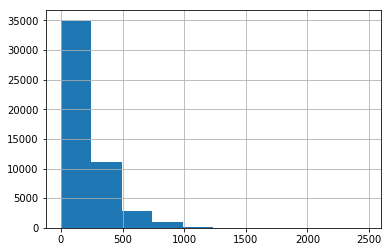

count    50001.000000
mean       230.249895
std        170.661355
min          0.000000
25%        126.000000
50%        172.000000
75%        280.000000
max       2469.000000
dtype: float64

In [24]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

Removing Outliers — Getting rid of extremely long or short reviews

Observations : a) Mean review length = 240 b) Some reviews are of 0 length. Keeping this review won’t make any sense for our analysis c) Most of the reviews less than 500 words or more d) There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis

In [25]:
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

Padding / Truncating the remaining data

To deal with both short and long reviews, we will pad or truncate all our reviews to a specific length - Sequence Length - tje same as number of time steps for LSTM layer.

For reviews shorter than seq_length, we will pad with 0s. For reviews longer than seq_length we will truncate them to the first seq_length words.

In [26]:
def pad_features(reviews_int, seq_length):
    ''' 
        Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = float)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

features = pad_features(reviews_int, 200)

In [27]:
print("Features Length: ", len(features))
print("Labels Length: ", len(encoded_labels))
features1 = features[0:12500]
features2 = features[12500:25000]
features3 = features[25000:37500]
features4 = features[37500:50000]
features_pos = np.concatenate((features2, features4))
features_neg = np.concatenate((features1, features3))
print("Positive Features: ", len(features_pos))
print("Negative Features: ", len(features_neg))
labels1 = encoded_labels[0:12500]
labels2 = encoded_labels[12500:25000]
labels3 = encoded_labels[25000:37500]
labels4 = encoded_labels[37500:50000]
labels_pos = labels2 + labels4
labels_neg = labels1 + labels3
print("Positive Labels: ", len(labels_pos))
print("Negative Labels: ", len(labels_neg))


Features Length:  50000
Labels Length:  50000
Positive Features:  25000
Negative Features:  25000
Positive Labels:  25000
Negative Labels:  25000


In [28]:
print(features)

[[     0.      0.      0. ... 100922. 161024.  97114.]
 [ 34722.  93925. 100922. ... 163828.  68894. 149723.]
 [120910.  47949.  47813. ... 157378.  56987.  45049.]
 ...
 [  6738. 153802. 150377. ...   4137. 112884.  34890.]
 [     0.      0.      0. ... 172851. 172667.  99989.]
 [     0.      0.      0. ... 166017.  27161.  66234.]]


In [29]:
print(features[:10,:])

[[     0.      0.      0. ... 100922. 161024.  97114.]
 [ 34722.  93925. 100922. ... 163828.  68894. 149723.]
 [120910.  47949.  47813. ... 157378.  56987.  45049.]
 ...
 [     0.      0.      0. ...  64253.  40500. 162312.]
 [     0.      0.      0. ...   8401.  95282.  49105.]
 [     0.      0.      0. ... 127598.  10399.  66234.]]


Training, Validation, Test Dataset Split

train= 80% | valid = 10% | test = 10%

In [30]:
# split_frac = 0.5
# len_feat = len(features)
# train_x = features[0:int(split_frac*len_feat)]
# train_x = np.asarray(train_x, dtype=np.float32)
# train_y = encoded_labels[0:int(split_frac*len_feat)]
# train_y = np.asarray(train_y, dtype=np.float32)
# remaining_x = features[int(split_frac*len_feat):]
# remaining_x = np.asarray(remaining_x, dtype=np.float32)
# remaining_y = encoded_labels[int(split_frac*len_feat):]
# remaining_y = np.asarray(remaining_y, dtype=np.float32)
# valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
# valid_x = np.asarray(valid_x, dtype=np.float32)
# valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
# valid_y = np.asarray(valid_y, dtype=np.float32)
# test_x = remaining_x[int(len(remaining_x)*0.5):]
# text_x = np.asarray(test_x, dtype=np.float32)
# test_y = remaining_y[int(len(remaining_y)*0.5):]
# test_y = np.asarray(test_y, dtype=np.float32)



train_percent = .8
print(int(len(features_pos)*train_percent))
train_x = np.concatenate((features_pos[0:int(len(features_pos)*train_percent)], features_neg[0:int(len(features_neg)*train_percent)]))
train_x = np.asarray(train_x, dtype=np.float32)
train_y = labels_pos[0:int(len(labels_pos)*train_percent)] + labels_neg[0:int(len(labels_neg)*train_percent)]
train_y = np.asarray(train_y, dtype=np.float32)

features_pos = features_pos[int(len(features_pos)*train_percent):]
features_neg = features_neg[int(len(features_neg)*train_percent):]
labels_pos = labels_pos[int(len(labels_pos)*train_percent):]
labels_neg = labels_neg[int(len(labels_neg)*train_percent):]

valid_x = np.concatenate((features_pos[0:int(len(features_pos)*.5)], features_neg[0:int(len(features_neg)*.5)]))
valid_x = np.asarray(valid_x, dtype=np.float32)
valid_y = labels_pos[0:int(len(labels_pos)*.5)] + labels_neg[0:int(len(labels_neg)*.5)]
valid_y = np.asarray(valid_y, dtype=np.float32)

features_pos = features_pos[int(len(features_pos)*.5):]
features_neg = features_neg[int(len(features_neg)*.5):]
labels_pos = labels_pos[int(len(labels_pos)*.5):]
labels_neg = labels_neg[int(len(labels_neg)*.5):]

test_x = np.concatenate((features_pos, features_neg))
test_x = np.asarray(test_x, dtype=np.float32)
test_y = labels_pos + labels_neg
test_y = np.asarray(test_y, dtype=np.float32)


20000


In [31]:
len(train_x)

40000

Dataloaders and Batching

In [32]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In order to obtain one batch of training data for visualization purpose we will create a data iterator

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Batch Size = 50;
Sequence Length = 200;

Define the LSTM Network Architecture

![alt text](files/network_arch.png "Title")

Define Model Class

In [ ]:
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
#         self.dropout = nn.Dropout(0.5)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

Training the Network

In [ ]:
# Instantiate the model w/ hyperparams
# vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
vocab_size = len(vocab)+1
output_size = 1
embedding_dim = 300
# embedding_dim = 100
hidden_dim = 256
n_layers = 4
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
#UPDATING PYTORCH EMBEDDINGS
net.embedding.weight.data = torch.Tensor(weights)
print(net)

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 12 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping
train_on_gpu = True
# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()

t_loss = []
v_loss = []
plt.figure()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        inputs = inputs.cuda()
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                inputs = inputs.cuda()
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            """
                PLOT EPOCHS IN GRAPH
            """
            t_loss.append(loss.item())
            v_loss.append(np.mean(val_losses))
            plt.plot(t_loss)
            plt.plot(v_loss)
            plt.show()
            clear_output(wait=True)

Testing

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    inputs = inputs.cuda()
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

User Generated Data

In [ ]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([word2id[word] for word in test_words])

    return test_ints


test_review_neg = "Awful movie. Never will I ever recommend it to anyone."

# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)


# test sequence padding
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)


# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())


def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [ ]:
test_review = 'This movie had the best acting and the dialogue was so good. I loved it. Great movie'
seq_length=200 # good to use the length that was trained on
predict(net, test_review_neg, seq_length)
predict(net, test_review, seq_length)